In [8]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

In [9]:
f = open("classes.txt")
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,rice leaf roller
1,2,rice leaf caterpillar
2,3,paddy stem maggot
3,4,asiatic rice borer
4,5,yellow rice borer


In [10]:
train_df = pd.read_csv('PlantYOLO/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('PlantYOLO/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('PlantYOLO/val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

,image_path,label
0,00002.jpg,0
1,00003.jpg,0
2,00005.jpg,0
3,00006.jpg,0
4,00008.jpg,0


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
TRAIN_DIR = "PlantYOLO/images/train"
VAL_DIR = "PlantYOLO/images/val"
TEST_DIR = "PlantYOLO/images/test"

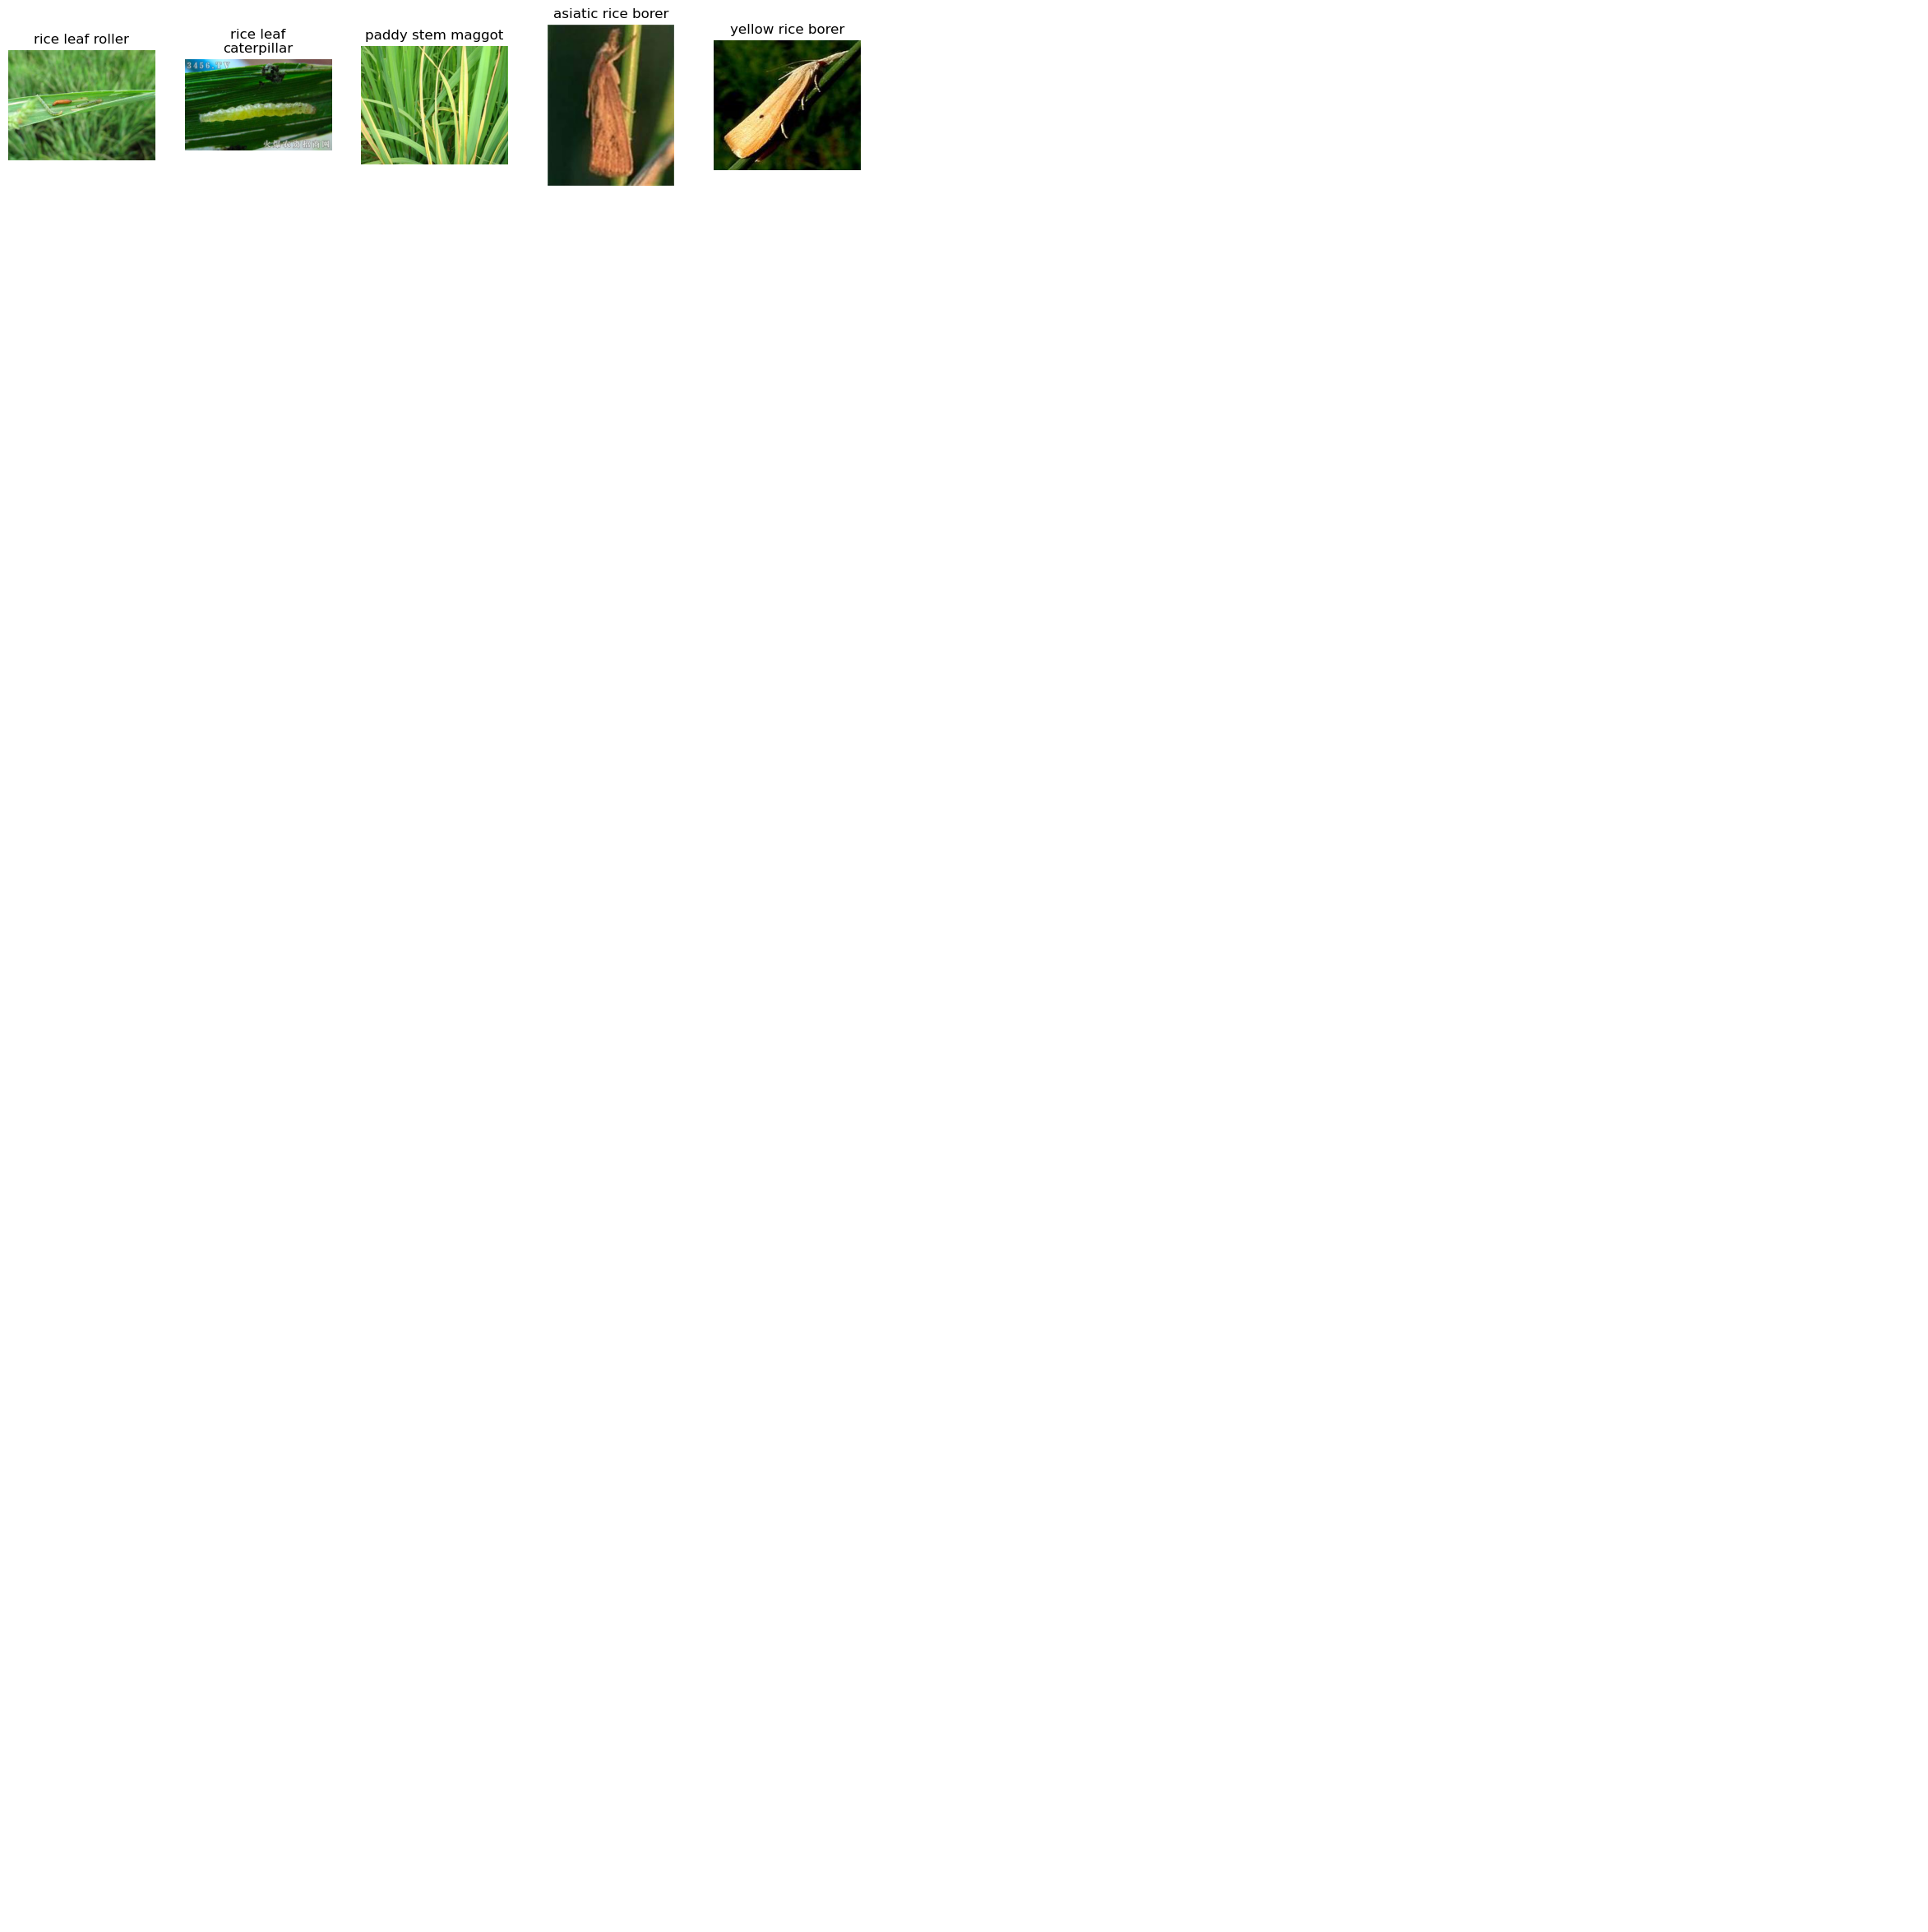

In [13]:
TRAIN_DIR = "PlantYOLO/images/train"
VAL_DIR = "PlantYOLO/images/val"
TEST_DIR = "PlantYOLO/images/test"
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values)
    label = classes.name[i-1]
    img = plt.imread(os.path.join(TRAIN_DIR, random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

In [14]:
class InsectModel(nn.Module):
    def __init__(self,num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
    def forward(self, image):
        return self.model(image)
model = InsectModel(num_classes=5)
model = model.to(device)

In [15]:
def train_transform():
    return A.Compose([
        A.HorizontalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.Resize(224, 224),
        ToTensorV2()])

def valid_transform():
    return A.Compose([
        A.Resize(224,224),
        ToTensorV2()])

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transforms=None):
        self.image_info = image
        self.transforms = transforms
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        # Remove label subfolder for train images
        image_path = os.path.join(self.imgdir, image_info[0])
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        label = image_info[1]

        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [18]:
BATCH_SIZE = 16
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transforms=train_transform())
train_data_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transforms=valid_transform())
val_data_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=0)

In [19]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss,correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n
        
        self.avg = self.sum / self.count
        self.acc = self.correct / self.count
        
class Accuracy(object):
    def __init__(self):
        self.reset

In [20]:
def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    criterion.train()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking = True).float()
        labels = labels.to(device, non_blocking = True).long()
    
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()
        
        summary.update(loss.item(),correct, BATCH_SIZE)
        tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    criterion.eval()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    with torch.no_grad():
        for step, (images, labels) in enumerate(tk0):
            images = images.to(device, non_blocking = True).float()
            labels = labels.to(device, non_blocking = True).long()
            
            output = model(images)
            loss = criterion(output, labels)
            
            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()
            
            summary.update(loss.item(), correct, BATCH_SIZE)
            tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary
    

In [21]:
os.environ['WANDB_CONSOLE'] = 'off'
EPOCH = 100
LR=1e-3

def run():
    model = InsectModel(num_classes=5)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    best_loss = 10**5
    for epoch in range(0, EPOCH):
        train_loss = train_fn(train_data_loader, model, criterion, device, optimizer, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), f'vit_best.pth')
        print(f'Epoch {epoch+1+0:03}: | Train Loss: {train_loss.avg:.5f} | Val Loss: {val_loss.avg:.5f}')

In [22]:
if __name__ == "__main__":
    BATCH_SIZE = 32
    train_dataset = InsectDataset(image=train_df.values, 
                                  image_dir=TRAIN_DIR, 
                                  transforms=train_transform())
    train_data_loader = DataLoader(train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=0)  # can increase safely

    val_dataset = InsectDataset(image=val_df.values,
                                image_dir=VAL_DIR,
                                transforms=valid_transform())
    val_data_loader = DataLoader(val_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=0)

    # your model, optimizer, training loop calls
    run()


100%|██████████| 11/11 [00:05<00:00,  1.90it/s, acc=0.284, epoch=1, loss=1.48]


Epoch 001: | Train Loss: 1.96159 | Val Loss: 1.48314


100%|██████████| 11/11 [00:05<00:00,  1.96it/s, acc=0.315, epoch=2, loss=1.51]


Epoch 002: | Train Loss: 1.56636 | Val Loss: 1.51176


100%|██████████| 11/11 [00:05<00:00,  2.02it/s, acc=0.324, epoch=3, loss=1.49]


Epoch 003: | Train Loss: 1.53871 | Val Loss: 1.49212


100%|██████████| 11/11 [00:05<00:00,  2.01it/s, acc=0.31, epoch=4, loss=1.53]


Epoch 004: | Train Loss: 1.51294 | Val Loss: 1.52675


100%|██████████| 11/11 [00:05<00:00,  1.98it/s, acc=0.384, epoch=5, loss=1.51]


Epoch 005: | Train Loss: 1.53255 | Val Loss: 1.51472


100%|██████████| 11/11 [00:05<00:00,  1.94it/s, acc=0.315, epoch=6, loss=1.62]


Epoch 006: | Train Loss: 1.48081 | Val Loss: 1.62433


100%|██████████| 11/11 [00:05<00:00,  1.95it/s, acc=0.406, epoch=7, loss=1.45]


Epoch 007: | Train Loss: 1.47767 | Val Loss: 1.44984


100%|██████████| 11/11 [00:05<00:00,  2.02it/s, acc=0.44, epoch=8, loss=1.45] 


Epoch 008: | Train Loss: 1.47477 | Val Loss: 1.44683


100%|██████████| 11/11 [00:05<00:00,  2.03it/s, acc=0.429, epoch=9, loss=1.43]


Epoch 009: | Train Loss: 1.43605 | Val Loss: 1.42607


100%|██████████| 11/11 [00:05<00:00,  2.00it/s, acc=0.406, epoch=10, loss=1.46]


Epoch 010: | Train Loss: 1.41786 | Val Loss: 1.45819


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.332, epoch=11, loss=1.54]


Epoch 011: | Train Loss: 1.44094 | Val Loss: 1.53723


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.426, epoch=12, loss=1.42]


Epoch 012: | Train Loss: 1.44763 | Val Loss: 1.41818


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.46, epoch=13, loss=1.41] 


Epoch 013: | Train Loss: 1.42675 | Val Loss: 1.40501


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.443, epoch=14, loss=1.42]


Epoch 014: | Train Loss: 1.44499 | Val Loss: 1.41541


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.349, epoch=15, loss=1.49]


Epoch 015: | Train Loss: 1.42103 | Val Loss: 1.48619


100%|██████████| 11/11 [00:05<00:00,  1.95it/s, acc=0.446, epoch=16, loss=1.4] 


Epoch 016: | Train Loss: 1.41843 | Val Loss: 1.39677


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.432, epoch=17, loss=1.42]


Epoch 017: | Train Loss: 1.41650 | Val Loss: 1.41765


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.415, epoch=18, loss=1.46]


Epoch 018: | Train Loss: 1.40777 | Val Loss: 1.45960


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.42, epoch=19, loss=1.41] 


Epoch 019: | Train Loss: 1.43930 | Val Loss: 1.40972


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.46, epoch=20, loss=1.39] 


Epoch 020: | Train Loss: 1.40804 | Val Loss: 1.39243


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.443, epoch=21, loss=1.42]


Epoch 021: | Train Loss: 1.39146 | Val Loss: 1.42464


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.344, epoch=22, loss=1.49]


Epoch 022: | Train Loss: 1.41791 | Val Loss: 1.49137


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.452, epoch=23, loss=1.39]


Epoch 023: | Train Loss: 1.42161 | Val Loss: 1.38748


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.438, epoch=24, loss=1.4]


Epoch 024: | Train Loss: 1.40688 | Val Loss: 1.39858


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.42, epoch=25, loss=1.46] 


Epoch 025: | Train Loss: 1.39986 | Val Loss: 1.46093


100%|██████████| 11/11 [00:05<00:00,  1.90it/s, acc=0.432, epoch=26, loss=1.39]


Epoch 026: | Train Loss: 1.39754 | Val Loss: 1.38679


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.446, epoch=27, loss=1.43]


Epoch 027: | Train Loss: 1.41199 | Val Loss: 1.43158


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.42, epoch=28, loss=1.41] 


Epoch 028: | Train Loss: 1.45089 | Val Loss: 1.40702


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.429, epoch=29, loss=1.39]


Epoch 029: | Train Loss: 1.42256 | Val Loss: 1.39209


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.418, epoch=30, loss=1.42]


Epoch 030: | Train Loss: 1.44328 | Val Loss: 1.41624


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.432, epoch=31, loss=1.41]


Epoch 031: | Train Loss: 1.43365 | Val Loss: 1.41409


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.389, epoch=32, loss=1.46]


Epoch 032: | Train Loss: 1.40352 | Val Loss: 1.46245


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.375, epoch=33, loss=1.49]


Epoch 033: | Train Loss: 1.43825 | Val Loss: 1.48607


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.281, epoch=34, loss=1.52]


Epoch 034: | Train Loss: 1.43826 | Val Loss: 1.52409


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.446, epoch=35, loss=1.4]


Epoch 035: | Train Loss: 1.42748 | Val Loss: 1.40005


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.315, epoch=36, loss=1.79]


Epoch 036: | Train Loss: 1.42595 | Val Loss: 1.78792


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.412, epoch=37, loss=1.45]


Epoch 037: | Train Loss: 1.47806 | Val Loss: 1.44547


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.33, epoch=38, loss=1.48] 


Epoch 038: | Train Loss: 1.45806 | Val Loss: 1.47783


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.395, epoch=39, loss=1.44]


Epoch 039: | Train Loss: 1.44590 | Val Loss: 1.44076


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.435, epoch=40, loss=1.42]


Epoch 040: | Train Loss: 1.45404 | Val Loss: 1.42005


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.438, epoch=41, loss=1.42]


Epoch 041: | Train Loss: 1.42776 | Val Loss: 1.41538


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.429, epoch=42, loss=1.42]


Epoch 042: | Train Loss: 1.43252 | Val Loss: 1.41911


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.426, epoch=43, loss=1.41]


Epoch 043: | Train Loss: 1.43508 | Val Loss: 1.41150


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.418, epoch=44, loss=1.44]


Epoch 044: | Train Loss: 1.44546 | Val Loss: 1.44203


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.398, epoch=45, loss=1.44]


Epoch 045: | Train Loss: 1.44460 | Val Loss: 1.44433


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.429, epoch=46, loss=1.42]


Epoch 046: | Train Loss: 1.42714 | Val Loss: 1.42164


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.406, epoch=47, loss=1.43]


Epoch 047: | Train Loss: 1.42206 | Val Loss: 1.43174


100%|██████████| 11/11 [00:05<00:00,  1.90it/s, acc=0.398, epoch=48, loss=1.43]


Epoch 048: | Train Loss: 1.41934 | Val Loss: 1.43215


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.432, epoch=49, loss=1.43]


Epoch 049: | Train Loss: 1.42599 | Val Loss: 1.42915


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.435, epoch=50, loss=1.43]


Epoch 050: | Train Loss: 1.41076 | Val Loss: 1.43107


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.347, epoch=51, loss=1.47]


Epoch 051: | Train Loss: 1.41205 | Val Loss: 1.46680


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.403, epoch=52, loss=1.44]


Epoch 052: | Train Loss: 1.44731 | Val Loss: 1.44149


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.418, epoch=53, loss=1.42]


Epoch 053: | Train Loss: 1.42585 | Val Loss: 1.42135


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.418, epoch=54, loss=1.44]


Epoch 054: | Train Loss: 1.43315 | Val Loss: 1.43809


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.42, epoch=55, loss=1.45] 


Epoch 055: | Train Loss: 1.41605 | Val Loss: 1.44786


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.415, epoch=56, loss=1.45]


Epoch 056: | Train Loss: 1.42759 | Val Loss: 1.45202


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.418, epoch=57, loss=1.44]


Epoch 057: | Train Loss: 1.42799 | Val Loss: 1.43782


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.42, epoch=58, loss=1.44] 


Epoch 058: | Train Loss: 1.40914 | Val Loss: 1.44282


100%|██████████| 11/11 [00:05<00:00,  1.95it/s, acc=0.432, epoch=59, loss=1.43]


Epoch 059: | Train Loss: 1.40156 | Val Loss: 1.42705


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.432, epoch=60, loss=1.4] 


Epoch 060: | Train Loss: 1.40873 | Val Loss: 1.40450


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.449, epoch=61, loss=1.4] 


Epoch 061: | Train Loss: 1.41459 | Val Loss: 1.39858


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.44, epoch=62, loss=1.43] 


Epoch 062: | Train Loss: 1.41020 | Val Loss: 1.43018


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.42, epoch=63, loss=1.46] 


Epoch 063: | Train Loss: 1.40531 | Val Loss: 1.46053


100%|██████████| 11/11 [00:05<00:00,  1.90it/s, acc=0.347, epoch=64, loss=1.54]


Epoch 064: | Train Loss: 1.43091 | Val Loss: 1.54068


100%|██████████| 11/11 [00:05<00:00,  1.90it/s, acc=0.423, epoch=65, loss=1.43]


Epoch 065: | Train Loss: 1.41715 | Val Loss: 1.42893


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.429, epoch=66, loss=1.45]


Epoch 066: | Train Loss: 1.41779 | Val Loss: 1.45277


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.42, epoch=67, loss=1.41]


Epoch 067: | Train Loss: 1.41688 | Val Loss: 1.41388


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.415, epoch=68, loss=1.41]


Epoch 068: | Train Loss: 1.39607 | Val Loss: 1.40691


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.418, epoch=69, loss=1.43]


Epoch 069: | Train Loss: 1.42087 | Val Loss: 1.42845


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.423, epoch=70, loss=1.42]


Epoch 070: | Train Loss: 1.40780 | Val Loss: 1.41875


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.438, epoch=71, loss=1.41]


Epoch 071: | Train Loss: 1.40910 | Val Loss: 1.40743


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.432, epoch=72, loss=1.46]


Epoch 072: | Train Loss: 1.40860 | Val Loss: 1.45615


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.406, epoch=73, loss=1.42]


Epoch 073: | Train Loss: 1.43393 | Val Loss: 1.41853


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.435, epoch=74, loss=1.42]


Epoch 074: | Train Loss: 1.40592 | Val Loss: 1.41609


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.409, epoch=75, loss=1.43]


Epoch 075: | Train Loss: 1.41683 | Val Loss: 1.43499


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.426, epoch=76, loss=1.43]


Epoch 076: | Train Loss: 1.44501 | Val Loss: 1.43362


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.429, epoch=77, loss=1.42]


Epoch 077: | Train Loss: 1.43719 | Val Loss: 1.41667


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.412, epoch=78, loss=1.45]


Epoch 078: | Train Loss: 1.41995 | Val Loss: 1.44944


100%|██████████| 11/11 [00:05<00:00,  1.94it/s, acc=0.435, epoch=79, loss=1.41]


Epoch 079: | Train Loss: 1.43911 | Val Loss: 1.41368


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.426, epoch=80, loss=1.43]


Epoch 080: | Train Loss: 1.40255 | Val Loss: 1.42687


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.426, epoch=81, loss=1.42]


Epoch 081: | Train Loss: 1.40617 | Val Loss: 1.41567


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.432, epoch=82, loss=1.4]


Epoch 082: | Train Loss: 1.39549 | Val Loss: 1.39896


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.423, epoch=83, loss=1.41]


Epoch 083: | Train Loss: 1.42345 | Val Loss: 1.41139


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.423, epoch=84, loss=1.42]


Epoch 084: | Train Loss: 1.40770 | Val Loss: 1.41733


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.406, epoch=85, loss=1.42]


Epoch 085: | Train Loss: 1.40481 | Val Loss: 1.41862


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.423, epoch=86, loss=1.47]


Epoch 086: | Train Loss: 1.39669 | Val Loss: 1.47313


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.386, epoch=87, loss=1.47]


Epoch 087: | Train Loss: 1.44076 | Val Loss: 1.46978


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.392, epoch=88, loss=1.45]


Epoch 088: | Train Loss: 1.42179 | Val Loss: 1.45138


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.438, epoch=89, loss=1.41]


Epoch 089: | Train Loss: 1.42604 | Val Loss: 1.41138


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.432, epoch=90, loss=1.43]


Epoch 090: | Train Loss: 1.42310 | Val Loss: 1.42573


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.44, epoch=91, loss=1.43] 


Epoch 091: | Train Loss: 1.41176 | Val Loss: 1.43195


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.42, epoch=92, loss=1.41] 


Epoch 092: | Train Loss: 1.40940 | Val Loss: 1.41356


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.432, epoch=93, loss=1.42]


Epoch 093: | Train Loss: 1.42275 | Val Loss: 1.42090


100%|██████████| 11/11 [00:05<00:00,  1.93it/s, acc=0.435, epoch=94, loss=1.45]


Epoch 094: | Train Loss: 1.39749 | Val Loss: 1.44614


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.42, epoch=95, loss=1.44] 


Epoch 095: | Train Loss: 1.39694 | Val Loss: 1.44034


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.403, epoch=96, loss=1.43]


Epoch 096: | Train Loss: 1.40834 | Val Loss: 1.43453


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.406, epoch=97, loss=1.46]


Epoch 097: | Train Loss: 1.40783 | Val Loss: 1.45560


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.42, epoch=98, loss=1.45] 


Epoch 098: | Train Loss: 1.43079 | Val Loss: 1.44645


100%|██████████| 11/11 [00:05<00:00,  1.92it/s, acc=0.42, epoch=99, loss=1.43] 


Epoch 099: | Train Loss: 1.41576 | Val Loss: 1.42987


100%|██████████| 11/11 [00:05<00:00,  1.91it/s, acc=0.432, epoch=100, loss=1.41]

Epoch 100: | Train Loss: 1.42685 | Val Loss: 1.41481


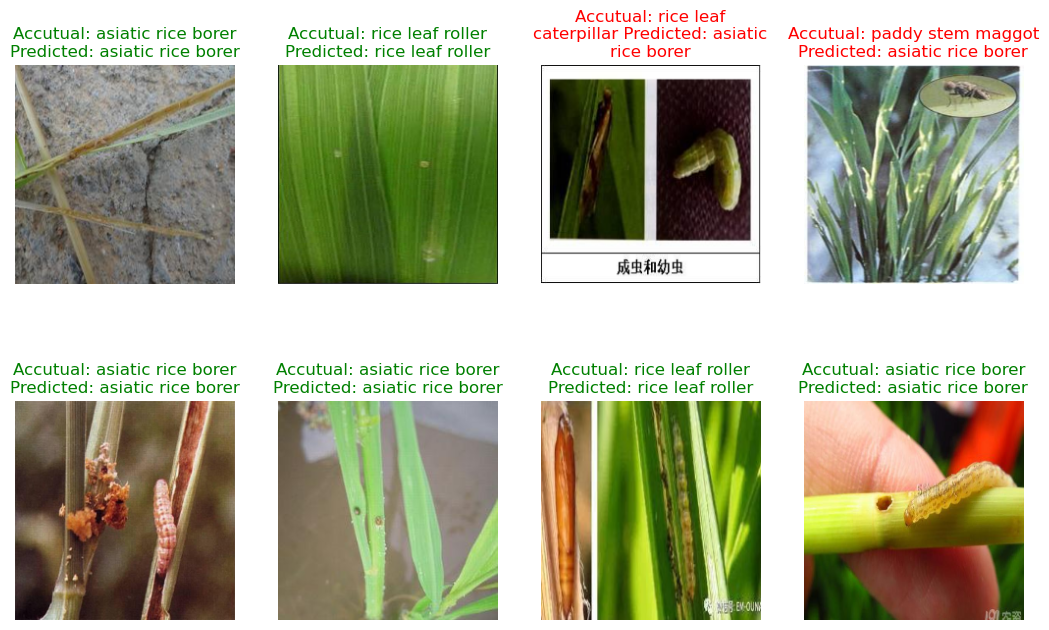

In [27]:
model = InsectModel(num_classes=5)
model.load_state_dict(torch.load("./vit_best.pth"))
images, labels = next(iter(val_data_loader))
preds = model(images).softmax(1).argmax(1)

fig, axs = plt.subplots(2,4,figsize=(13,8))
[ax.imshow(image.permute((1,2,0))) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(f'Accutual: {classes.name[label.item()]} Predicted: {classes.name[pred.item()]}',30)),color = 'g' if label.item()==pred.item() else 'r') for label,pred,ax in zip(labels,preds,axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()
model = model.to(device)

In [28]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

uploader = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
display(uploader)

def on_upload_change(change):
    if uploader.value:
        file_info = next(iter(uploader.value.values()))
        img = Image.open(file_info['content']).convert("RGB")
        img_resized = img.resize((224, 224))
        img_np = np.array(img_resized) / 255.0
        img_tensor = torch.tensor(img_np, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

        model = InsectModel(num_classes=5)
        model.load_state_dict(torch.load("vit_best.pth", map_location="cpu"))
        model.eval()

        classes = [line.strip().split(' ', 1)[1] for line in open('classes.txt')]

        with torch.no_grad():
            output = model(img_tensor)
            pred = output.softmax(1).argmax(1).item()
            predicted_label = classes[pred]

        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label}")
        plt.axis('off')
        plt.show()

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')